In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import numpy as np

In [2]:
# Dataset path
dataset_path = r"C:\Users\HP\OneDrive\Desktop\Minor Project 6 th sem\dataset\farm_insects"

In [3]:
# Image settings
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

In [4]:
# Fix PIL transparency issue
def convert_image(img):
    if isinstance(img, np.ndarray):  # Check if input is already an image array
        return img
    img = Image.open(img)
    if img.mode in ("P", "RGBA"):  # Convert Palette/Transparent images to RGB
        img = img.convert("RGB")
    return np.array(img)

In [5]:
# Data augmentation (removed `preprocessing_function` to avoid error)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2
)

In [6]:
# Load training data
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

Found 1269 images belonging to 14 classes.


In [7]:
# Load validation data
val_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

Found 310 images belonging to 14 classes.


In [8]:
# Load EfficientNetB0 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [9]:
# Enable fine-tuning for better learning
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

In [10]:
# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(train_data.num_classes, activation='softmax')(x)

In [11]:
# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

In [12]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [15]:
# Train the model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 749s 16s/step - accuracy: 0.1144 - loss: 3.0614 - val_accuracy: 0.3419 - val_loss: 2.2594 - learning_rate: 1.0000e-04
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1011s 25s/step - accuracy: 0.2225 - loss: 2.3823 - val_accuracy: 0.4710 - val_loss: 1.9538 - learning_rate: 1.0000e-04
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 981s 25s/step - accuracy: 0.3701 - loss: 2.0479 - val_accuracy: 0.5290 - val_loss: 1.5572 - learning_rate: 1.0000e-04
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 770s 19s/step - accuracy: 0.4636 - loss: 1.7276 - val_accuracy: 0.5355 - val_loss: 1.3766 - learning_rate: 1.0000e-04
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 591s 15s/step - accuracy: 0.5421 - loss: 1.4749 - val_accuracy: 0.6323 - val_loss: 1.1516 - learning_rate: 1.0000e-04
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 580s 14s/step - accuracy: 0.5861 - loss: 1.2931 - val_accuracy: 0.6516 - val_loss: 1.0635 - learning_rate: 1.0000e-04
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 596s 15s/step - accuracy:

In [16]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7335 - loss: 1.0195
Validation Accuracy: 77.74%


In [17]:
# Save the model
model.save("pest_detection_model2_v2.h5")

In [18]:
import matplotlib.pyplot as plt

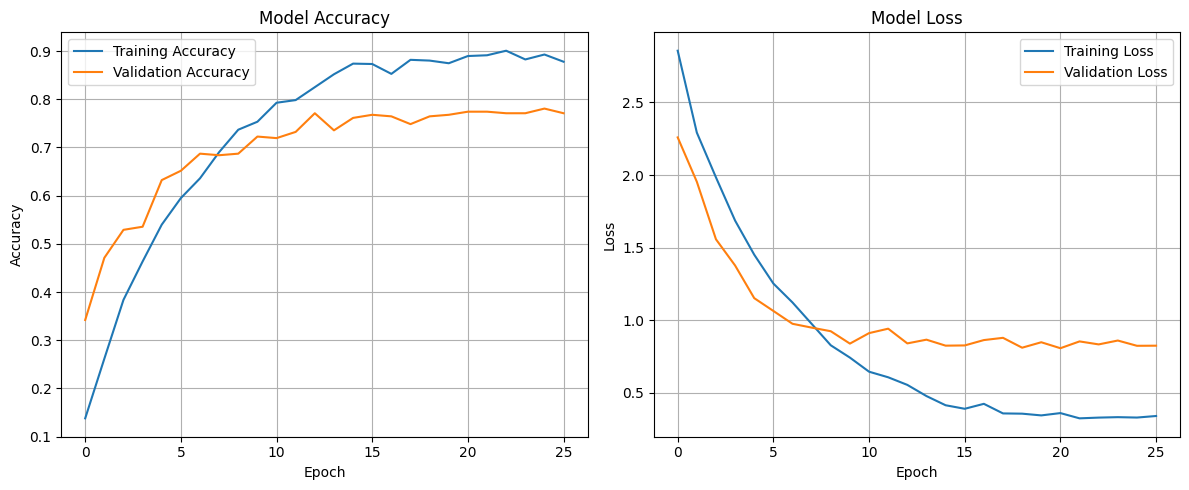

In [19]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
final_train_acc = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc:.4f}")


Final Training Accuracy: 0.8779


In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step


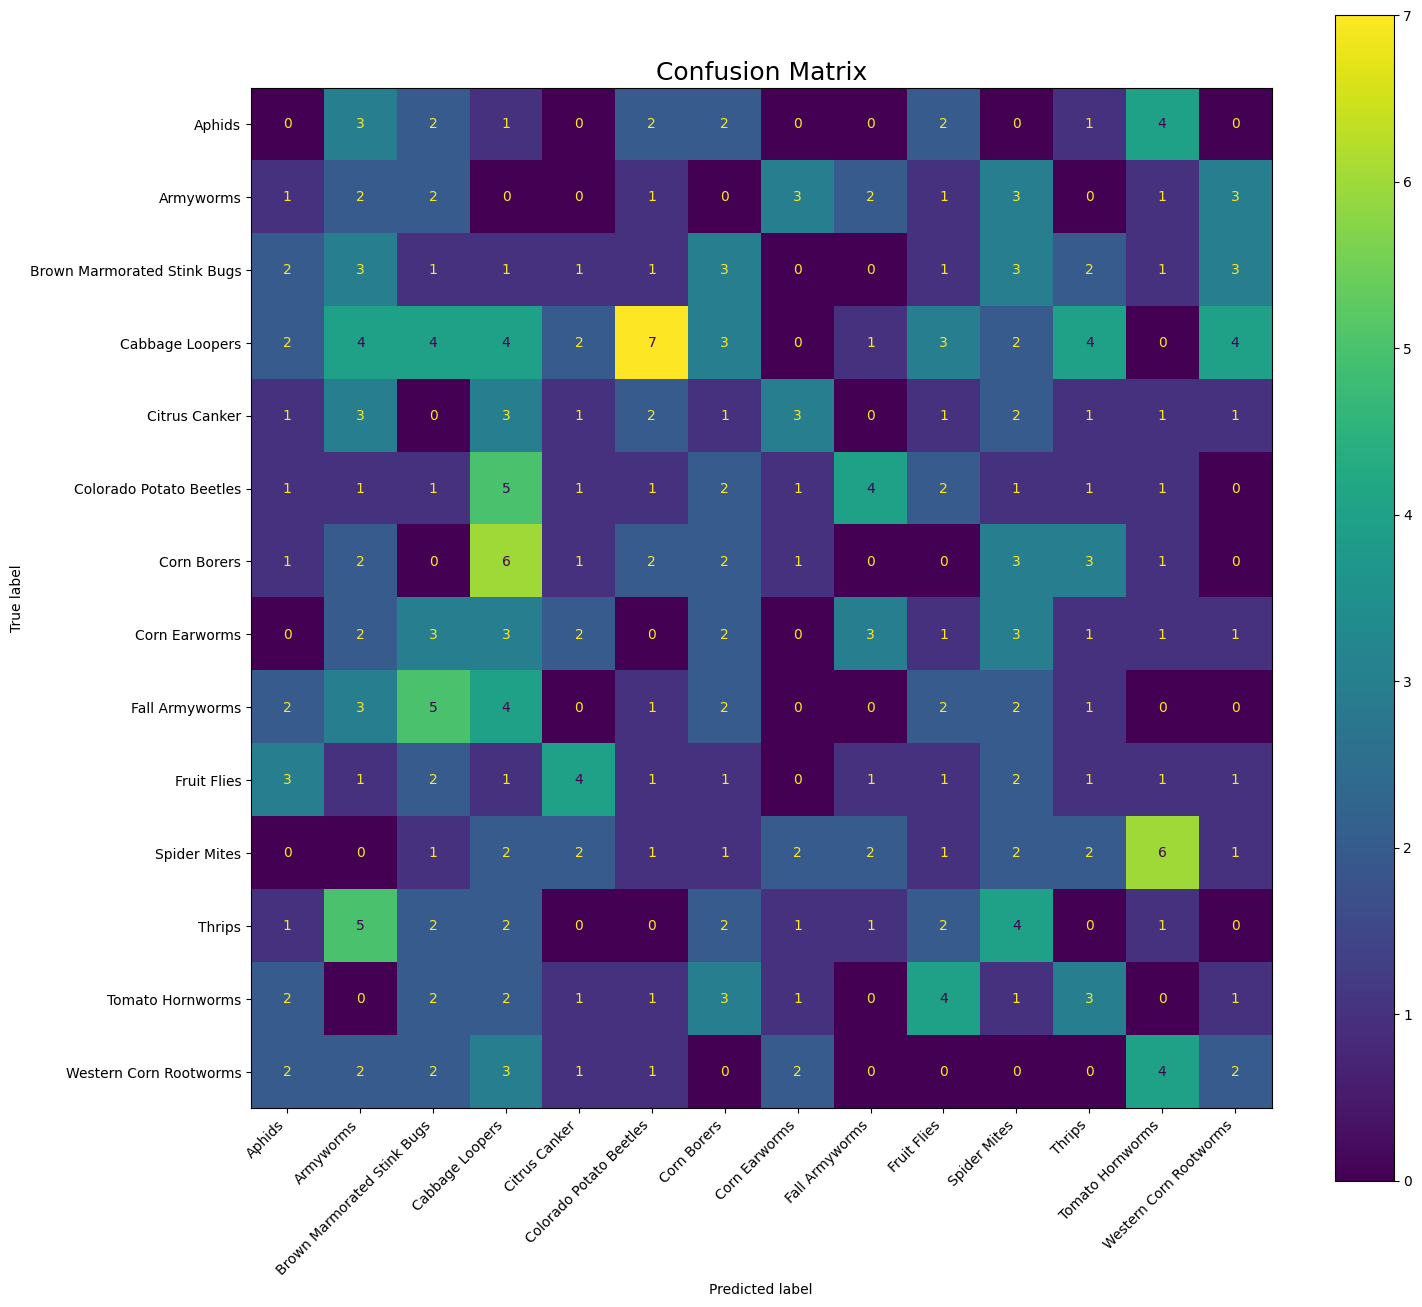

In [ ]:

val_data.reset()

# Predict and get class indices
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot with more space
fig, ax = plt.subplots(figsize=(16, 14))  # Larger figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(
    cmap='viridis',
    xticks_rotation=45,
    values_format='d',
    ax=ax
)
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout(pad=3.0)  # Add padding to avoid cutoff
plt.grid(False)
plt.show()